In [1]:
import sys
sys.path.append('./../')
from datetime import datetime
from src import proyecto_1
from src.pipelines import modeling
from src.pipelines import model_evaluation
from src.utils import utils

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, accuracy_score
import sklearn.metrics as metrics

./../src/pipelines/feature_engineering.py:21: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.inputs = df.drop(['latitud', 'longitud', 'codigo_cierre','fecha_creacion','incidente_c4'], axis=1)
/home/yusuri/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/yusuri/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


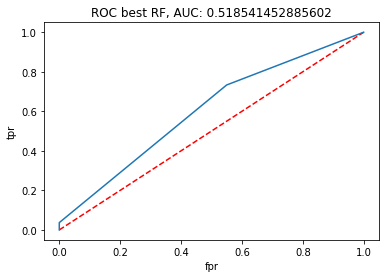

In [2]:
proyecto_1.main()

In [3]:
models = utils.load_df('output/model_loop.pkl')

In [4]:
models[0].best_estimator_

DecisionTreeClassifier(max_depth=1, min_samples_leaf=2, random_state=123)

In [5]:
models[1].best_estimator_

RandomForestClassifier(max_depth=1, min_samples_leaf=2, oob_score=True,
                       random_state=123)

In [6]:
#model_evaluation.model_evaluation('./output/model_loop.pkl')

In [ ]:
#utils.load_df('./output/metricas_offline.pkl')

In [7]:
def load_model(path):
    model = utils.load_df('output/model_loop.pkl')
    return model

In [8]:
#Carga de datos de train y test
c5_train = utils.load_df('output/fe_df.pkl')
c5_test = utils.load_df('output/test.pkl')
#Preparacion de datos test
c5_test_ = c5_test.copy()
c5_train_ = c5_train.copy()
c5_train_ = c5_train_.drop('label',axis=1)
names=np.array(c5_test_.dia_semana.unique())
names=np.append(names,np.array(c5_test_.delegacion_inicio.unique()))
names=np.append(names,np.array(c5_test_.clas_con_f_alarma.unique()))
names=np.append(names,np.array(c5_test_.tipo_entrada.unique()))
names=np.append(names,np.array(['año','mes','sin_time', 'cos_time']))   
#Definicion de transformers
transformers = [('one_hot', OneHotEncoder(), [ 'dia_semana','delegacion_inicio','clas_con_f_alarma','tipo_entrada']),
        ('año', SimpleImputer(strategy="mean"), ['año_creacion']),
        ('mes', SimpleImputer(strategy="mean"), ['mes']),
        ('impute_sin_time', SimpleImputer(strategy="median"), ['sin_time']),
        ('impute_cos_time', SimpleImputer(strategy="median"), ['cos_time'])]
col_trans = ColumnTransformer(transformers, remainder="drop", n_jobs=-1, verbose=True)
col_trans.fit(c5_test_)
df_input_vars = col_trans.transform(c5_test_)
X = df_input_vars
y = c5_test.label.values.reshape(df_input_vars.shape[0],)
    
X_test = pd.DataFrame.sparse.from_spmatrix(X)
X_test.columns = names
X_test
selection_test = list(c5_train_.columns)
selection_test
X_test_ = X_test[selection_test]
prediction = (models[1].best_estimator_.predict_proba(X_test_)[:,1] >= 0.206002).astype(bool)
proba = models[1].best_estimator_.predict_proba(X_test_)

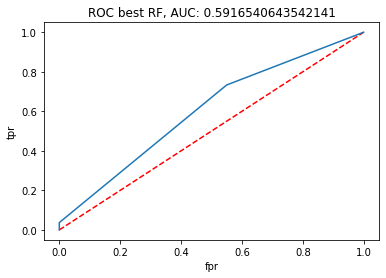

In [9]:
#%matplotlib inline
#Plot curva ROC
    
fpr, tpr, thresholds = roc_curve(y, proba[:,1], pos_label=1)
    
plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y, prediction)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

In [10]:
#Plot matriz de confusion

(confusion_matrix(y, prediction))

array([[ 99025, 120961],
       [ 15082,  41440]])

In [11]:
#Plot accuracy

accuracy_score(y, prediction)

0.5079961520100684

In [12]:
# Plot oprecision, recall, thresholds
    
precision, recall, thresholds_2 = precision_recall_curve(y, proba[:,1], pos_label=1)
thresholds_2 = np.append(thresholds_2, 1)

In [13]:
#Reporte de metricas
    
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                        'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
        
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
        
    df = df_1.merge(df_2, on="threshold")
    return df
        
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.159563,0.204414,1.000000,0.339441,1.000000,1.000000,0.000000,0.000000
1,0.209916,0.255171,0.733166,0.378581,0.733166,0.549858,0.450142,0.266834
2,0.231504,0.944223,0.037738,0.072574,0.037738,0.000573,0.999427,0.962262
3,0.506574,1.000000,0.037083,0.071514,0.037083,0.000000,1.000000,0.962917


In [14]:
#Precision&recall @k
    
def precision_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return metrics.precision_score(y_true, y_pred)

In [15]:
def recall_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return metrics.recall_score(y_true, y_pred)

In [16]:
def get_top_k(y,y_scores,k):
    array=np.stack((y, y_scores), axis=-1)
    ordena_k = array[np.argsort(array[:, 1])[::-1]]
    k_porc = int(len(y_scores)*k)
    top = ordena_k[:k_porc]
    return top[:,[0]],top[:,[1]]

In [17]:
def pr_k_curve(y_true, y_scores, save_target):
    k_values = list(np.arange(0.01, 1, 0.01))
    pr_k = pd.DataFrame()

    for k in k_values:
        d = dict()
        d['k'] = k
         ## get_top_k es una función que ordena los scores de
         ## mayor a menor y toma los k% primeros
         #top_k_y,top_k_proba = get_top_k(y_true,y_scores, k)
         #d['precision'] = precision_at_k(top_k_y,top_k_proba,k)
         #d['recall'] = recall_at_k(top_k_y,top_k_proba,k)
        d['precision'] = precision_at_k(y_true, y_scores,k)
        d['recall'] = recall_at_k(y_true, y_scores, k)

        pr_k = pr_k.append(d, ignore_index=True)

    # para la gráfica
    fig, ax1 = plt.subplots()
    ax1.plot(pr_k['k'], pr_k['precision'], label='precision')
    ax1.plot(pr_k['k'], pr_k['recall'], label='recall')
    #ax1.plot([k,k],[1,0], 'k--', c='red')
    
    plt.legend()
    
    c5 = utils.load_df('output/ingest_df.pkl')
    min_fecha = '01/01/2014'
    max_fecha = '12/10/2020'
    min_fecha = datetime.strptime(min_fecha, '%d/%m/%Y')
    max_fecha = datetime.strptime(max_fecha, '%d/%m/%Y')
    dias = max_fecha-min_fecha
    dias
    ambulancias = 20
    dias=2476
    acc = c5['dia_semana'].count()
    acc_x_dia = acc/dias
    k = ambulancias / acc_x_dia
    k
    
    plt.axvline(x=k)

    #if save_target is not None:
    #    plt.savefig(save_target)

    return pr_k

,k,precision,recall
0,0.01,0.255171,0.733166
1,0.02,0.255171,0.733166
2,0.03,0.255171,0.733166
3,0.04,0.255171,0.733166
4,0.05,0.255171,0.733166
...,...,...,...
94,0.95,0.204414,1.000000
95,0.96,0.204414,1.000000
96,0.97,0.204414,1.000000
97,0.98,0.204414,1.000000


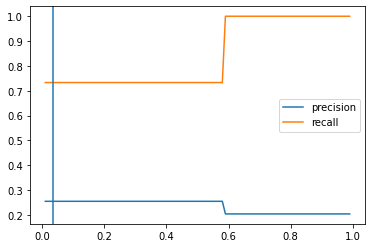

In [18]:
pr_k_curve(y, proba[:,1],0)

## Aequitas

In [19]:
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

In [20]:
c5_aeq = pd.DataFrame({'score':prediction, 'label_value': y, 'delegacion': c5_test['delegacion_inicio']})

In [21]:
c5_aeq['delegacion'] = c5_aeq['delegacion'].astype(str)

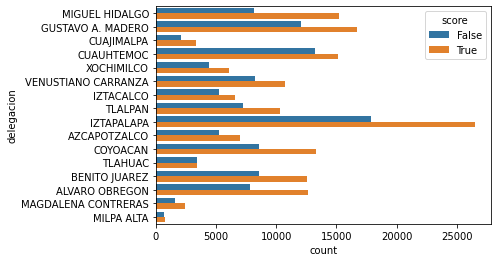

In [22]:
by_delegacion = sns.countplot(y="delegacion", hue="score", data=c5_aeq)

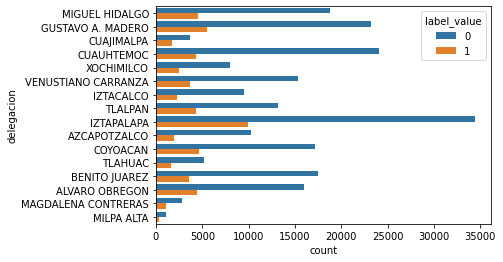

In [23]:
by_delegacion = sns.countplot(y="delegacion", hue="label_value", data=c5_aeq)

### Group

In [24]:
g = Group()
xtab, attrbs = g.get_crosstabs(c5_aeq)

model_id, score_thresholds 0 {'rank_abs': [162401]}


In [25]:
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,162401,delegacion,ALVARO OBREGON,0.732991,0.413828,0.153599,0.739805,0.586172,...,0.618402,9343,1197,6596,3286,4483,15939,20422,276508,0.219518
1,0,binary 0/1,162401,delegacion,AZCAPOTZALCO,0.698276,0.451185,0.113963,0.803398,0.548815,...,0.572924,5627,595,4626,1377,1972,10253,12225,276508,0.161309
2,0,binary 0/1,162401,delegacion,BENITO JUAREZ,0.750209,0.437468,0.105035,0.784859,0.562532,...,0.594530,9828,897,7643,2694,3591,17471,21062,276508,0.170497
3,0,binary 0/1,162401,delegacion,COYOACAN,0.763862,0.432653,0.129172,0.732112,0.567347,...,0.609342,9751,1103,7436,3568,4671,17187,21858,276508,0.213698
4,0,binary 0/1,162401,delegacion,CUAJIMALPA,0.680412,0.412668,0.270480,0.643243,0.587332,...,0.617467,2142,558,1505,1188,1746,3647,5393,276508,0.323753
5,0,binary 0/1,162401,delegacion,CUAUHTEMOC,0.694244,0.495777,0.099176,0.802702,0.504223,...,0.533006,12120,1312,11917,2979,4291,24037,28328,276508,0.151476
6,0,binary 0/1,162401,delegacion,GUSTAVO A. MADERO,0.746984,0.458749,0.116404,0.752077,0.541251,...,0.580917,12583,1405,10665,4148,5553,23248,28801,276508,0.192806
7,0,binary 0/1,162401,delegacion,IZTACALCO,0.705240,0.481532,0.128547,0.753134,0.518468,...,0.554736,4927,675,4576,1615,2290,9503,11793,276508,0.194183
8,0,binary 0/1,162401,delegacion,IZTAPALAPA,0.739144,0.443753,0.145256,0.722465,0.556247,...,0.597263,19141,2595,15270,7353,9948,34411,44359,276508,0.224261
9,0,binary 0/1,162401,delegacion,MAGDALENA CONTRERAS,0.744403,0.447469,0.176093,0.664847,0.552531,...,0.604775,1583,274,1282,798,1072,2865,3937,276508,0.272289


In [26]:
absolute_metrics = g.list_absolute_metrics(xtab)

Frecuencias

In [27]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,162401,delegacion,ALVARO OBREGON,12629,7793,9343,1197,6596,3286,4483,15939,20422,276508
1,0,binary 0/1,162401,delegacion,AZCAPOTZALCO,7004,5221,5627,595,4626,1377,1972,10253,12225,276508
2,0,binary 0/1,162401,delegacion,BENITO JUAREZ,12522,8540,9828,897,7643,2694,3591,17471,21062,276508
3,0,binary 0/1,162401,delegacion,COYOACAN,13319,8539,9751,1103,7436,3568,4671,17187,21858,276508
4,0,binary 0/1,162401,delegacion,CUAJIMALPA,3330,2063,2142,558,1505,1188,1746,3647,5393,276508
5,0,binary 0/1,162401,delegacion,CUAUHTEMOC,15099,13229,12120,1312,11917,2979,4291,24037,28328,276508
6,0,binary 0/1,162401,delegacion,GUSTAVO A. MADERO,16731,12070,12583,1405,10665,4148,5553,23248,28801,276508
7,0,binary 0/1,162401,delegacion,IZTACALCO,6542,5251,4927,675,4576,1615,2290,9503,11793,276508
8,0,binary 0/1,162401,delegacion,IZTAPALAPA,26494,17865,19141,2595,15270,7353,9948,34411,44359,276508
9,0,binary 0/1,162401,delegacion,MAGDALENA CONTRERAS,2381,1556,1583,274,1282,798,1072,2865,3937,276508


Absolutos

In [32]:
xtab[['attribute_name', 'attribute_value']+[col for col in xtab.columns if col in absolute_metrics]].round(4)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,delegacion,ALVARO OBREGON,0.7330,0.4138,0.1536,0.7398,0.5862,0.2670,0.8464,0.2602,0.0778,0.6184,0.2195
1,delegacion,AZCAPOTZALCO,0.6983,0.4512,0.1140,0.8034,0.5488,0.3017,0.8860,0.1966,0.0431,0.5729,0.1613
2,delegacion,BENITO JUAREZ,0.7502,0.4375,0.1050,0.7849,0.5625,0.2498,0.8950,0.2151,0.0771,0.5945,0.1705
3,delegacion,COYOACAN,0.7639,0.4327,0.1292,0.7321,0.5673,0.2361,0.8708,0.2679,0.0820,0.6093,0.2137
4,delegacion,CUAJIMALPA,0.6804,0.4127,0.2705,0.6432,0.5873,0.3196,0.7295,0.3568,0.0205,0.6175,0.3238
5,delegacion,CUAUHTEMOC,0.6942,0.4958,0.0992,0.8027,0.5042,0.3058,0.9008,0.1973,0.0930,0.5330,0.1515
6,delegacion,GUSTAVO A. MADERO,0.7470,0.4587,0.1164,0.7521,0.5413,0.2530,0.8836,0.2479,0.1030,0.5809,0.1928
7,delegacion,IZTACALCO,0.7052,0.4815,0.1285,0.7531,0.5185,0.2948,0.8715,0.2469,0.0403,0.5547,0.1942
8,delegacion,IZTAPALAPA,0.7391,0.4438,0.1453,0.7225,0.5562,0.2609,0.8547,0.2775,0.1631,0.5973,0.2243
9,delegacion,MAGDALENA CONTRERAS,0.7444,0.4475,0.1761,0.6648,0.5525,0.2556,0.8239,0.3352,0.0147,0.6048,0.2723


In [37]:
xtab.fpr.median().round(5)

0.54503

Vamos a tomar la Delegación Gustavo A. Madero como nuestro grupo de referencia pues la mediana de los fpr es la que más se acerca y así podremos ver si hay algún sesgo entre las demás delegaciones. 

Vamos a tomar las siguientes métricas:

PPR Predicted Positive Rate: Nos interesa para saber cuántas predijimos como falsas y realmente lo eran.

FPR False Positive Rate: Nos interesa para saber las que nos dice son falsas cuando realmente son verdaderas
nos interesa para mandar la ambulancia a quién la necesita.

FDR False Discovery Rate: Nos interesa para saber fracción de personas que realmente necesitan la ambulancia y fueron predichos como falsos.


Visualización de sesgo en los grupos

In [40]:
aeq = Plot()

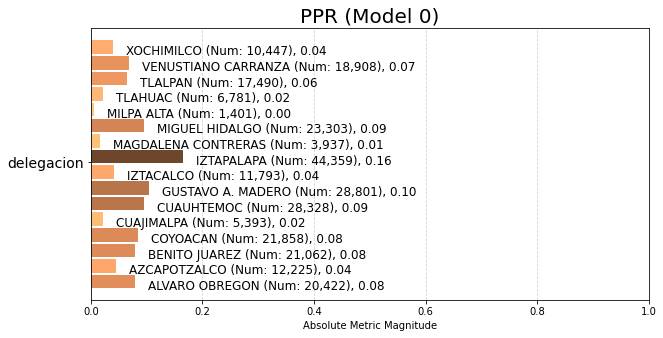

In [48]:
fdr = aeq.plot_group_metric(xtab, 'ppr')

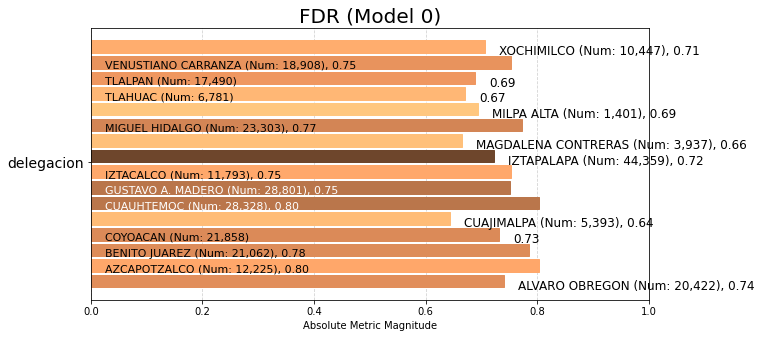

In [50]:
fdr = aeq.plot_group_metric(xtab, 'fdr')

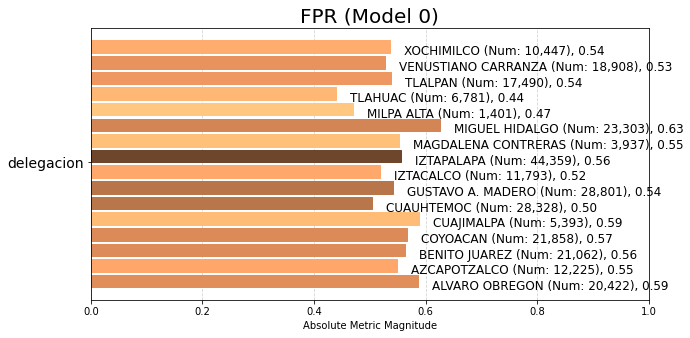

In [47]:
fdr = aeq.plot_group_metric(xtab, 'fpr')

### Bias

In [51]:
bias = Bias()

In [52]:
bdf = bias.get_disparity_predefined_groups(xtab, original_df=c5_aeq, 
                                        ref_groups_dict={'delegacion':'GUSTAVO A. MADERO'}, 
                                        alpha=0.05)

get_disparity_predefined_group()


In [54]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +
     bias.list_disparities(bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion,ALVARO OBREGON,0.75,1.06,1.05,0.98,1.32,1.08,1.06,0.98,0.90,0.96
1,delegacion,AZCAPOTZALCO,0.42,0.99,0.79,1.07,0.98,1.01,1.19,0.93,0.98,1.00
2,delegacion,BENITO JUAREZ,0.75,1.02,0.87,1.04,0.90,1.04,0.99,1.00,0.95,1.01
3,delegacion,COYOACAN,0.80,1.05,1.08,0.97,1.11,1.05,0.93,1.02,0.94,0.99
4,delegacion,CUAJIMALPA,0.20,1.06,1.44,0.86,2.32,1.09,1.26,0.91,0.90,0.83
5,delegacion,CUAUHTEMOC,0.90,0.92,0.80,1.07,0.85,0.93,1.21,0.93,1.08,1.02
6,delegacion,GUSTAVO A. MADERO,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
7,delegacion,IZTACALCO,0.39,0.95,1.00,1.00,1.10,0.96,1.16,0.94,1.05,0.99
8,delegacion,IZTAPALAPA,1.58,1.03,1.12,0.96,1.25,1.03,1.03,0.99,0.97,0.97
9,delegacion,MAGDALENA CONTRERAS,0.14,1.04,1.35,0.88,1.51,1.02,1.01,1.00,0.98,0.93


In [55]:
majority_bdf = bias.get_disparity_major_group(xtab, original_df=c5_aeq)

get_disparity_major_group()


In [56]:
majority_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(majority_bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion,ALVARO OBREGON,0.48,1.04,0.94,1.02,1.06,1.05,1.02,0.99,0.93,0.99
1,delegacion,AZCAPOTZALCO,0.26,0.96,0.71,1.11,0.78,0.99,1.16,0.94,1.02,1.04
2,delegacion,BENITO JUAREZ,0.47,1.00,0.78,1.09,0.72,1.01,0.96,1.01,0.99,1.05
3,delegacion,COYOACAN,0.50,1.02,0.97,1.01,0.89,1.02,0.91,1.03,0.97,1.02
4,delegacion,CUAJIMALPA,0.13,1.03,1.29,0.89,1.86,1.06,1.23,0.92,0.93,0.85
5,delegacion,CUAUHTEMOC,0.57,0.89,0.71,1.11,0.68,0.91,1.17,0.94,1.12,1.05
6,delegacion,GUSTAVO A. MADERO,0.63,0.97,0.89,1.04,0.80,0.97,0.97,1.01,1.03,1.03
7,delegacion,IZTACALCO,0.25,0.93,0.89,1.04,0.88,0.93,1.13,0.95,1.09,1.02
8,delegacion,IZTAPALAPA,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
9,delegacion,MAGDALENA CONTRERAS,0.09,1.01,1.21,0.92,1.21,0.99,0.98,1.01,1.01,0.96


In [57]:
min_bdf = bias.get_disparity_min_metric(xtab, original_df=c5_aeq)

get_disparity_min_metric()


In [58]:
min_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(min_bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion,ALVARO OBREGON,17.44,1.24,1.32,1.15,1.55,1.34,1.13,1.10,1.10,1.16
1,delegacion,AZCAPOTZALCO,9.67,1.15,1.00,1.25,1.15,1.25,1.28,1.05,1.20,1.21
2,delegacion,BENITO JUAREZ,17.30,1.19,1.09,1.22,1.06,1.28,1.06,1.13,1.17,1.23
3,delegacion,COYOACAN,18.40,1.22,1.36,1.14,1.30,1.29,1.00,1.15,1.15,1.19
4,delegacion,CUAJIMALPA,4.60,1.24,1.81,1.00,2.73,1.34,1.35,1.02,1.10,1.00
5,delegacion,CUAUHTEMOC,20.85,1.07,1.00,1.25,1.00,1.15,1.29,1.04,1.32,1.23
6,delegacion,GUSTAVO A. MADERO,23.11,1.17,1.26,1.17,1.17,1.23,1.07,1.12,1.22,1.21
7,delegacion,IZTACALCO,9.04,1.11,1.26,1.17,1.30,1.18,1.25,1.06,1.28,1.19
8,delegacion,IZTAPALAPA,36.59,1.20,1.41,1.12,1.46,1.27,1.10,1.11,1.18,1.17
9,delegacion,MAGDALENA CONTRERAS,3.29,1.21,1.70,1.03,1.78,1.26,1.08,1.12,1.19,1.13


Visualización de disparidades

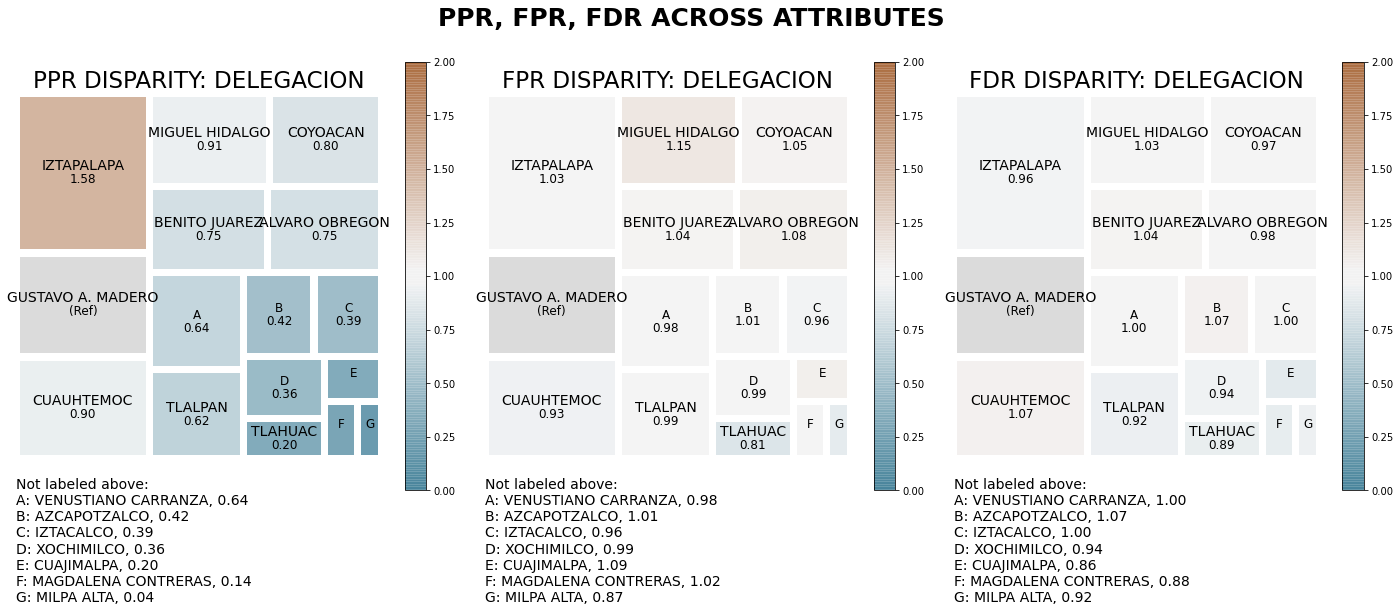

In [60]:
p = aeq.plot_disparity_all(bdf,  metrics=['ppr','fpr','fdr'], significance_alpha=0.05)

Para el sesgo:

En PPR Predicted Positive Rate podemos ver que nuestro modelo le está diciendo 1.58 veces más a la delegación Iztapalapa que las llamadas que se reciben son falsas.

### Fairness

In [65]:
fair = Fairness()

In [66]:
fdf = fair.get_group_value_fairness(bdf)

In [67]:
parity_determinations = fair.list_parities(fdf)

In [69]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + 
    bias.list_disparities(fdf) + parity_determinations].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,...,TNR Parity,Impact Parity,Equalized Odds,TypeI Parity,Precision Parity,FOR Parity,Statistical Parity,TypeII Parity,TPR Parity,Unsupervised Fairness
0,delegacion,ALVARO OBREGON,0.73,0.41,0.15,0.74,0.59,0.27,0.85,0.26,...,True,True,True,True,True,False,False,False,True,False
1,delegacion,AZCAPOTZALCO,0.70,0.45,0.11,0.80,0.55,0.30,0.89,0.20,...,True,True,True,True,False,True,False,True,True,False
2,delegacion,BENITO JUAREZ,0.75,0.44,0.11,0.78,0.56,0.25,0.89,0.22,...,True,True,True,True,True,True,False,True,True,False
3,delegacion,COYOACAN,0.76,0.43,0.13,0.73,0.57,0.24,0.87,0.27,...,True,True,True,True,True,True,False,True,True,False
4,delegacion,CUAJIMALPA,0.68,0.41,0.27,0.64,0.59,0.32,0.73,0.36,...,True,True,True,True,False,False,False,False,True,False
5,delegacion,CUAUHTEMOC,0.69,0.50,0.10,0.80,0.50,0.31,0.90,0.20,...,True,True,True,True,False,True,True,True,True,True
6,delegacion,GUSTAVO A. MADERO,0.75,0.46,0.12,0.75,0.54,0.25,0.88,0.25,...,True,True,True,True,True,True,True,True,True,True
7,delegacion,IZTACALCO,0.71,0.48,0.13,0.75,0.52,0.29,0.87,0.25,...,True,True,True,True,True,True,False,True,True,False
8,delegacion,IZTAPALAPA,0.74,0.44,0.15,0.72,0.56,0.26,0.85,0.28,...,True,True,True,True,True,True,False,True,True,False
9,delegacion,MAGDALENA CONTRERAS,0.74,0.45,0.18,0.66,0.55,0.26,0.82,0.34,...,True,True,True,True,False,False,False,False,True,False


In [70]:
gaf = fair.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,delegacion,False,True,True,True,False,False,True,True,True,False,True,False,True,False,False


In [71]:
fdf

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,162401,delegacion,ALVARO OBREGON,0.732991,0.413828,0.153599,0.739805,0.586172,...,True,True,True,True,True,True,False,True,False,False
1,0,binary 0/1,162401,delegacion,AZCAPOTZALCO,0.698276,0.451185,0.113963,0.803398,0.548815,...,True,True,True,True,False,True,True,True,False,True
2,0,binary 0/1,162401,delegacion,BENITO JUAREZ,0.750209,0.437468,0.105035,0.784859,0.562532,...,True,True,True,True,True,True,True,True,False,True
3,0,binary 0/1,162401,delegacion,COYOACAN,0.763862,0.432653,0.129172,0.732112,0.567347,...,True,True,True,True,True,True,True,True,False,True
4,0,binary 0/1,162401,delegacion,CUAJIMALPA,0.680412,0.412668,0.270480,0.643243,0.587332,...,False,True,True,True,False,True,False,True,False,False
5,0,binary 0/1,162401,delegacion,CUAUHTEMOC,0.694244,0.495777,0.099176,0.802702,0.504223,...,True,True,True,True,False,True,True,True,True,True
6,0,binary 0/1,162401,delegacion,GUSTAVO A. MADERO,0.746984,0.458749,0.116404,0.752077,0.541251,...,True,True,True,True,True,True,True,True,True,True
7,0,binary 0/1,162401,delegacion,IZTACALCO,0.705240,0.481532,0.128547,0.753134,0.518468,...,True,True,True,True,True,True,True,True,False,True
8,0,binary 0/1,162401,delegacion,IZTAPALAPA,0.739144,0.443753,0.145256,0.722465,0.556247,...,True,True,True,True,True,True,True,True,False,True
9,0,binary 0/1,162401,delegacion,MAGDALENA CONTRERAS,0.744403,0.447469,0.176093,0.664847,0.552531,...,True,True,True,True,False,True,False,True,False,False


In [72]:
gof = fair.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

Visualización de equidad

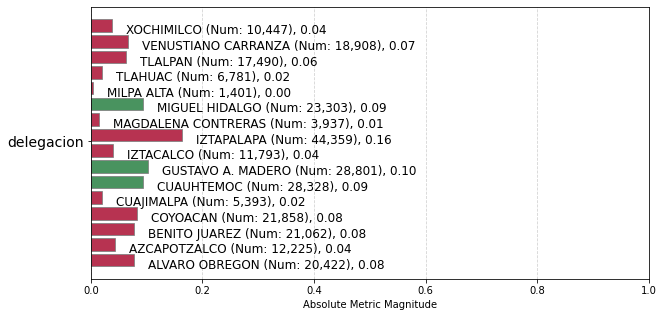

In [76]:
z = aeq.plot_fairness_group(fdf, group_metric='ppr')

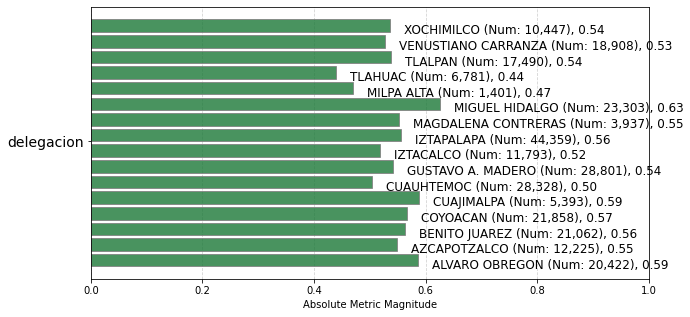

In [77]:
z = aeq.plot_fairness_group(fdf, group_metric='fpr')

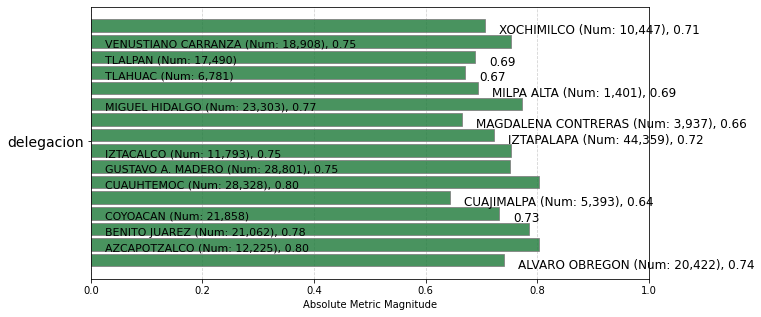

In [79]:
z = aeq.plot_fairness_group(fdf, group_metric='fdr')

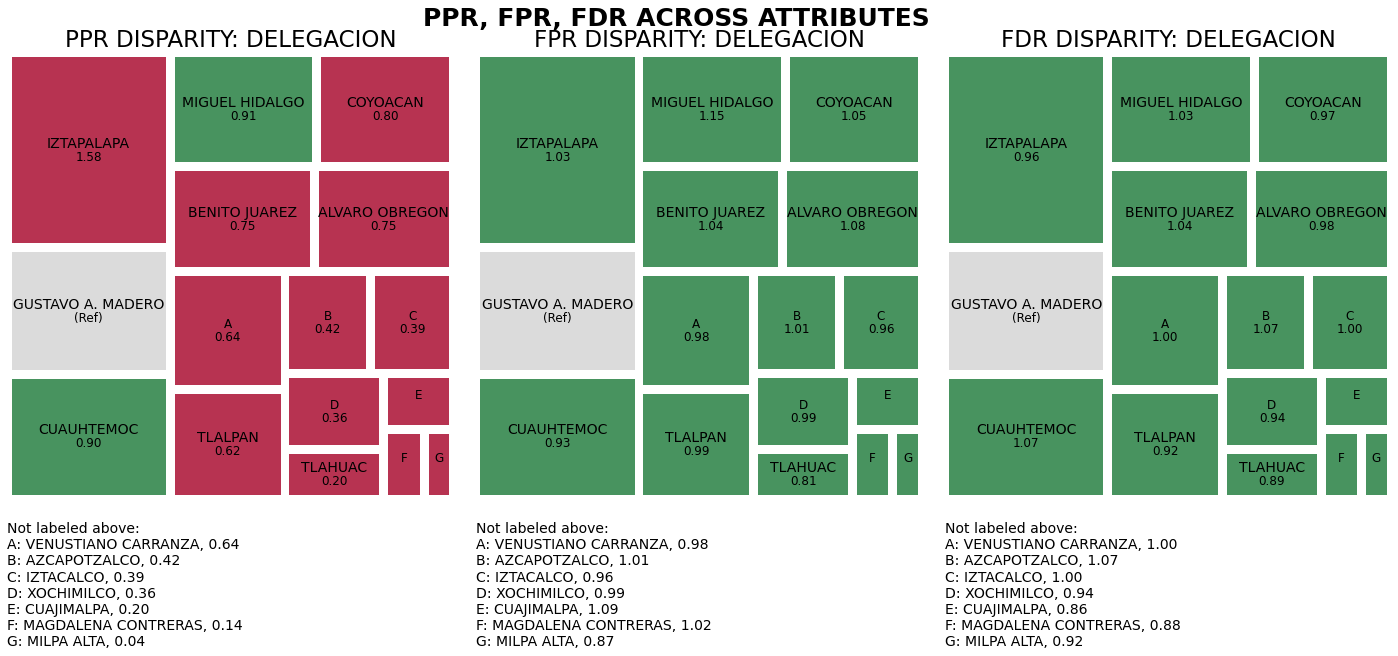

In [75]:
m = aeq.plot_fairness_disparity_all(fdf, metrics=['ppr','fpr','fdr'])

En PPR (Predicted Positive Rate):
Tenemos un sesgo en la mayoría de las delegaciones si tomamos como referencia a la delegación Gustavo A. Madero, las únicas dos que no tienen son Miguel Hidalgo y Cuauhtémoc. Esto nos indica que las ambulancias que se envían en éstas delegaciones realemnte lo necesitaban.

En las otras dos métricas que seleccionamos no hay sesgo